In [1]:
## auto reload
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
os.environ['OMP_PLACES'] = 'cores'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import jax

from srpe.utils.fs import PROJECT_ROOT
from srpe.utils.random_utils import seeding
from srpe.data.rod import create_rod_set
from srpe.model import BaselineModel, NeuralODEModel
from srpe.model.neuralode3 import NeuralODEModel as NeuralODEModel3
from srpe.trainer import Trainer
from srpe.trainer.callbacks import CallbackList
from srpe.utils.visualize import VisualizationCallback
from srpe.utils.plotter import RodPlotter
from srpe.utils.haiku_utils import print_model_size

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
## math cm
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
data_dir = PROJECT_ROOT / "data" / "rod"
batch_size = 1024
num_epochs = 20000

master_seed = 1
master_rng, _ = seeding(master_seed)
train_data_seed, test_data_seed, init_seed, train_seed = \
    map(int, master_rng.integers(0, 2**32, size=4))
init_key = jax.random.PRNGKey(init_seed)
train_key = jax.random.PRNGKey(train_seed)
del master_rng, master_seed, init_seed, train_seed

train_data_loader = create_rod_set(data_dir, "train", batch_size=batch_size, shuffle=True, seed=train_data_seed)
test_data_loader = create_rod_set(data_dir, "test", batch_size=1024, shuffle=True, seed=test_data_seed)
model_name = "srpe"


2023-11-04 21:38:42.227773: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-04 21:38:42.227894: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.125.6 does not match DSO version 525.147.5 -- cannot find working devices in this configuration
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data size: 40960; Batch size: 1024; Batches: 40; Discard: 0
Data size: 5120; Batch size: 1024; Batches: 5; Discard: 0


In [4]:
# log_dir = PROJECT_ROOT / "logs" / "srpe-20230406-152245"
def get_trainer(log_dir, policy_name):
    def model_fn(x, y=None, is_training=True):
        if policy_name == "mlp":
            model = BaselineModel()
        elif policy_name == "ode":
            model = NeuralODEModel()
        elif policy_name == "ode3":
            model = NeuralODEModel3()
        else:
            raise ValueError(f"Unknown policy name: {policy_name}")
        return model(x, y, is_training)

    trainer = Trainer(
        model_fn,
        train_data_loader,
        {
            "test": test_data_loader,
        },
        log_dir,
        lr=1e-4,
        trainable_predicate=lambda m, n, p: True,
        callback=CallbackList([
            VisualizationCallback(
                RodPlotter(test_data_loader.batch),
            )
        ])
    )
    return trainer


In [5]:
def get_result(trainer):
    predict_fn = trainer.predict
    test_data = test_data_loader.batch.data
    s_batch = test_data_loader.batch.data.query_position
    xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
    quaternion_batch = test_data_loader.batch.label.query_pose[:, :, 3:]
    batch_size = 1024
    num_batches = len(test_data) // batch_size
    res = [predict_fn(
        test_data[batch_index * batch_size: (batch_index + 1) * batch_size],
    ) for batch_index in range(num_batches)]
    res = jax.tree_util.tree_map(lambda *x: np.concatenate(x, axis=0), *res)
    res_xyz_batch = res[:, :, :3]
    # res_quaternion_batch = res[:, :, 3:]
    return xyz_batch, res_xyz_batch


In [6]:
mlp_log_dir = PROJECT_ROOT / "logs" / "srpe-20230406-170724"
ode_log_dir = PROJECT_ROOT / "logs" / "srpe-20230417-155740"
ode3_log_dir = PROJECT_ROOT / "logs" / "srpe-20230511-221203"
mlp_trainer = get_trainer(mlp_log_dir, "mlp")
mlp_trainer.load()
ode_trainer = get_trainer(ode_log_dir, "ode")
ode_trainer.load()
ode3_trainer = get_trainer(ode3_log_dir, "ode3")
ode3_trainer.load()

In [7]:
mlp_trainer.predict(test_data_loader.batch.data[0:1])
ode_trainer.predict(test_data_loader.batch.data[0:1])
ode3_trainer.predict(test_data_loader.batch.data[0:1])
# %timeit mlp_trainer.predict(test_data_loader.batch.data[0:1])
# %timeit ode_trainer.predict(test_data_loader.batch.data[0:1])
# %timeit ode3_trainer.predict(test_data_loader.batch.data[0:1])

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.32308929e-07, -3.71541482e-08,  2.02020211e-03],
        [ 1.59544948e-06, -1.97528735e-07,  4.04040422e-03],
        [ 4.17180172e-06, -6.14645387e-07,  6.06061611e-03],
        [ 8.52622543e-06, -1.27300643e-06,  8.08083825e-03],
        [ 1.51585873e-05, -2.08060192e-06,  1.01010557e-02],
        [ 2.45687625e-05, -2.94542269e-06,  1.21212602e-02],
        [ 3.72566356e-05, -3.77546075e-06,  1.41414423e-02],
        [ 5.37220731e-05, -4.47870616e-06,  1.61615890e-02],
        [ 7.44649369e-05, -4.96314942e-06,  1.81816872e-02],
        [ 9.99920885e-05, -5.11629059e-06,  2.02017315e-02],
        [ 1.30857195e-04, -4.66364554e-06,  2.22217441e-02],
        [ 1.67553997e-04, -3.46227080e-06,  2.42416859e-02],
        [ 2.10560960e-04, -1.41040800e-06,  2.62615122e-02],
        [ 2.60356377e-04,  1.59369881e-06,  2.82811746e-02],
        [ 3.17418657e-04,  5.65180972e-06,  3.03006265e-02],
        [ 3.82226193e-04

In [8]:
def plot_3d(xyz_sample_mm, res_xyz_sample_mm):
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_subplot(projection='3d')
    pre_rgb = (1, 0.92, 0.1)
    real_rgb = (0, 0, 0)
    ## plot x, y, z
    ax.plot(xyz_sample_mm[:, 0], xyz_sample_mm[:, 1], xyz_sample_mm[:, 2], c=real_rgb, linewidth=1, label='Real Shape')
    ax.plot(res_xyz_sample_mm[:, 0], res_xyz_sample_mm[:, 1], res_xyz_sample_mm[:, 2], c=pre_rgb, linewidth=1, label='Predicted Shape')
    ax.axis('equal')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    ax.legend()
    ax.zaxis.labelpad=0
    plt.tight_layout()
    ax.set_xlim3d(left=-100, right=100)
    ax.set_ylim3d(bottom=-100, top=100)

def plot_subplot3(s_sample_mm, xyz_sample_mm, res_xyz_sample_mm):
    fig, (axes_x, axes_y, axes_z) = plt.subplots(3, 1, dpi=150)
    pre_rgb = (1, 0.92, 0.1)
    real_rgb = (0, 0, 0)
    axes_x.plot(s_sample_mm, xyz_sample_mm[:, 0], color=real_rgb, label='Ground truth', linewidth=2.5)
    axes_x.plot(s_sample_mm, res_xyz_sample_mm[:, 0], color=pre_rgb, label='Prediction', linewidth=2.5, linestyle='--')
    axes_x.set_xlabel('Position [mm]')
    axes_x.set_ylabel('x [mm]')
    axes_x.legend()

    axes_y.plot(s_sample_mm, xyz_sample_mm[:, 1], color=real_rgb, label='Ground truth', linewidth=2.5)
    axes_y.plot(s_sample_mm, res_xyz_sample_mm[:, 1], color=pre_rgb, label='Prediction', linewidth=2.5, linestyle='--')
    axes_y.set_xlabel('Position [mm]')
    axes_y.set_ylabel('y [mm]')
    axes_y.legend()

    axes_z.plot(s_sample_mm, xyz_sample_mm[:, 2], color=real_rgb, label='Ground truth', linewidth=2.5)
    axes_z.plot(s_sample_mm, res_xyz_sample_mm[:, 2], color=pre_rgb, label='Prediction', linewidth=2.5, linestyle='--')
    axes_z.set_xlabel('Position [mm]')
    axes_z.set_ylabel('z [mm]')
    axes_z.legend()

    plt.tight_layout()
    ## grid
    axes_x.grid()
    axes_y.grid()
    axes_z.grid()


In [9]:
mlp_log_dir = PROJECT_ROOT / "logs" / "srpe-20230406-170724"
ode_log_dir = PROJECT_ROOT / "logs" / "srpe-20230417-155740"
# ode3_log_dir = PROJECT_ROOT / "logs" / "srpe-20230429-112748"
ode3_log_dir = PROJECT_ROOT / "logs" / "srpe-20230511-221203"
mlp_trainer = get_trainer(mlp_log_dir, "mlp")
mlp_trainer.load()
ode_trainer = get_trainer(ode_log_dir, "ode")
ode_trainer.load()
ode3_trainer = get_trainer(ode3_log_dir, "ode3")
ode3_trainer.load()
# mlp_predict = mlp_trainer.predict
xyz_batch_mlp, res_xyz_batch_mlp = get_result(mlp_trainer)
xyz_batch_ode, res_xyz_batch_ode = get_result(ode_trainer)
xyz_batch_ode3, res_xyz_batch_ode3 = get_result(ode3_trainer)
xyz_batch_mlp_error = np.linalg.norm(xyz_batch_mlp - res_xyz_batch_mlp, axis=-1)
xyz_batch_ode_error = np.linalg.norm(xyz_batch_ode - res_xyz_batch_ode, axis=-1)
xyz_batch_ode3_error = np.linalg.norm(xyz_batch_ode3 - res_xyz_batch_ode3, axis=-1)

/tmp/ipykernel_1862315/1046948938.py:5: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
/tmp/ipykernel_1862315/1046948938.py:6: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  quaternion_batch = test_data_loader.batch.label.query_pose[:, :, 3:]
/tmp/ipykernel_1862315/1046948938.py:5: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
/tmp/ipykernel_1862315/1046948938.py:6: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  quaternion_batch = test_data_loader.batch.label.query_pose[:, :, 3:]
/tmp/ipykernel_1862315/1046948938.py:5: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
/tmp/ipykernel_1862315/10469489

In [ ]:
# plt.hist(xyz_batch_mlp_error.flatten(), xyz_batch_ode_error.flatten, bins=100)
## plot hist
# fig, (axes_mlp, axes_ode) = plt.subplots(1, 2, dpi=150)
# axes_mlp.hist(xyz_batch_mlp_error.flatten(), bins=100)
# axes_mlp.set_title('MLP')
# axes_mlp.set_xlabel('Error [mm]')
# axes_mlp.set_ylabel('Count')
# axes_ode.hist(xyz_batch_ode_error.flatten(), bins=100)
# axes_ode.set_title('ODE')
# axes_ode.set_xlabel('Error [mm]')
# axes_ode.set_ylabel('Count')
# plt.tight_layout()
import pickle
# dump xyz_batch_mlp_error, xyz_batch_ode_error, xyz_batch_ode3_error
with open('/home/molumitu/code/srpe/result_pngs/xyz_batch_mlp_error.pkl', 'wb') as f:
    pickle.dump(xyz_batch_mlp_error, f)
with open('/home/molumitu/code/srpe/result_pngs/xyz_batch_ode_error.pkl', 'wb') as f:
    pickle.dump(xyz_batch_ode_error, f)
with open('/home/molumitu/code/srpe/result_pngs/xyz_batch_ode3_error.pkl', 'wb') as f:
    pickle.dump(xyz_batch_ode3_error, f)

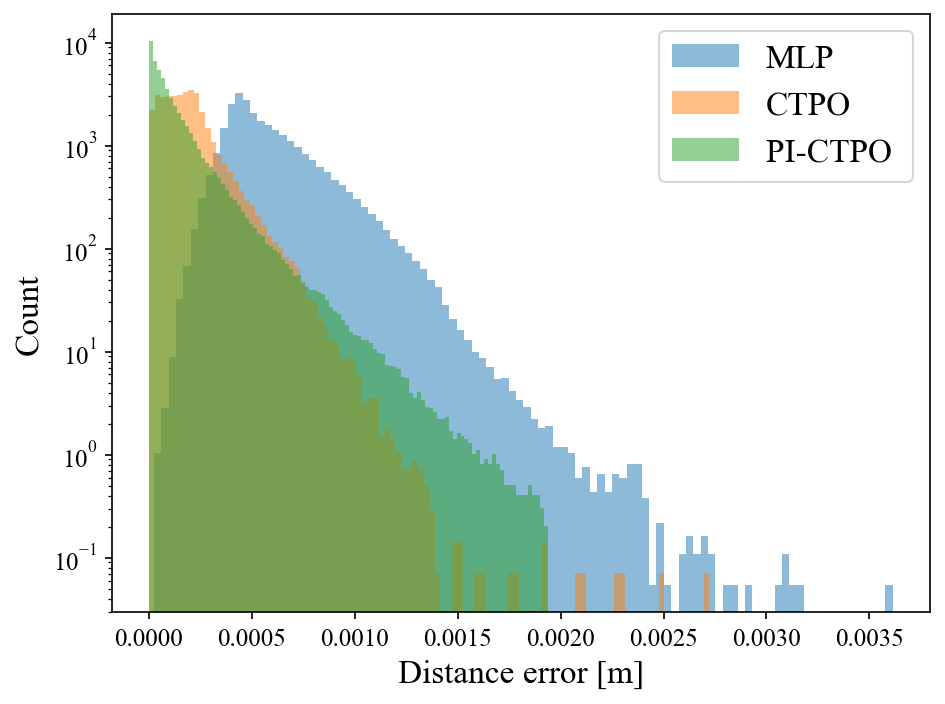

In [11]:
## plot hist on the same ax
fig, axes = plt.subplots(1, 1, dpi=150)
axes.hist(xyz_batch_mlp_error.flatten(), bins=100, label='MLP', alpha=0.5, density=True, log=True)
axes.hist(xyz_batch_ode_error.flatten(), bins=100, label='CTPO', alpha=0.5, density=True, log=True)
axes.hist(xyz_batch_ode3_error.flatten(), bins=100, label='PI-CTPO ', alpha=0.5, density=True, log=True)
axes.set_xlabel('Distance error [m]', fontsize=16)
axes.set_ylabel('Count', fontsize=16)
axes.legend(fontsize=16)
## ticks font size
axes.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('compare.png', dpi=300)


In [12]:
xyz_error_mean = np.mean(xyz_batch_ode_error, axis=-1)
indices = np.argsort(xyz_error_mean)


In [13]:
indices.shape
predict_fn = ode_trainer.predict
test_data = test_data_loader.batch.data
s_batch = test_data_loader.batch.data.query_position
xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
quaternion_batch = test_data_loader.batch.label.query_pose[:, :, 3:]

/tmp/ipykernel_1862315/3944808895.py:5: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  xyz_batch = test_data_loader.batch.label.query_pose[:, :, :3]
/tmp/ipykernel_1862315/3944808895.py:6: DeprecationWarning: Use `query_location` and `query_pose_quat` instead of `query_pose`
  quaternion_batch = test_data_loader.batch.label.query_pose[:, :, 3:]


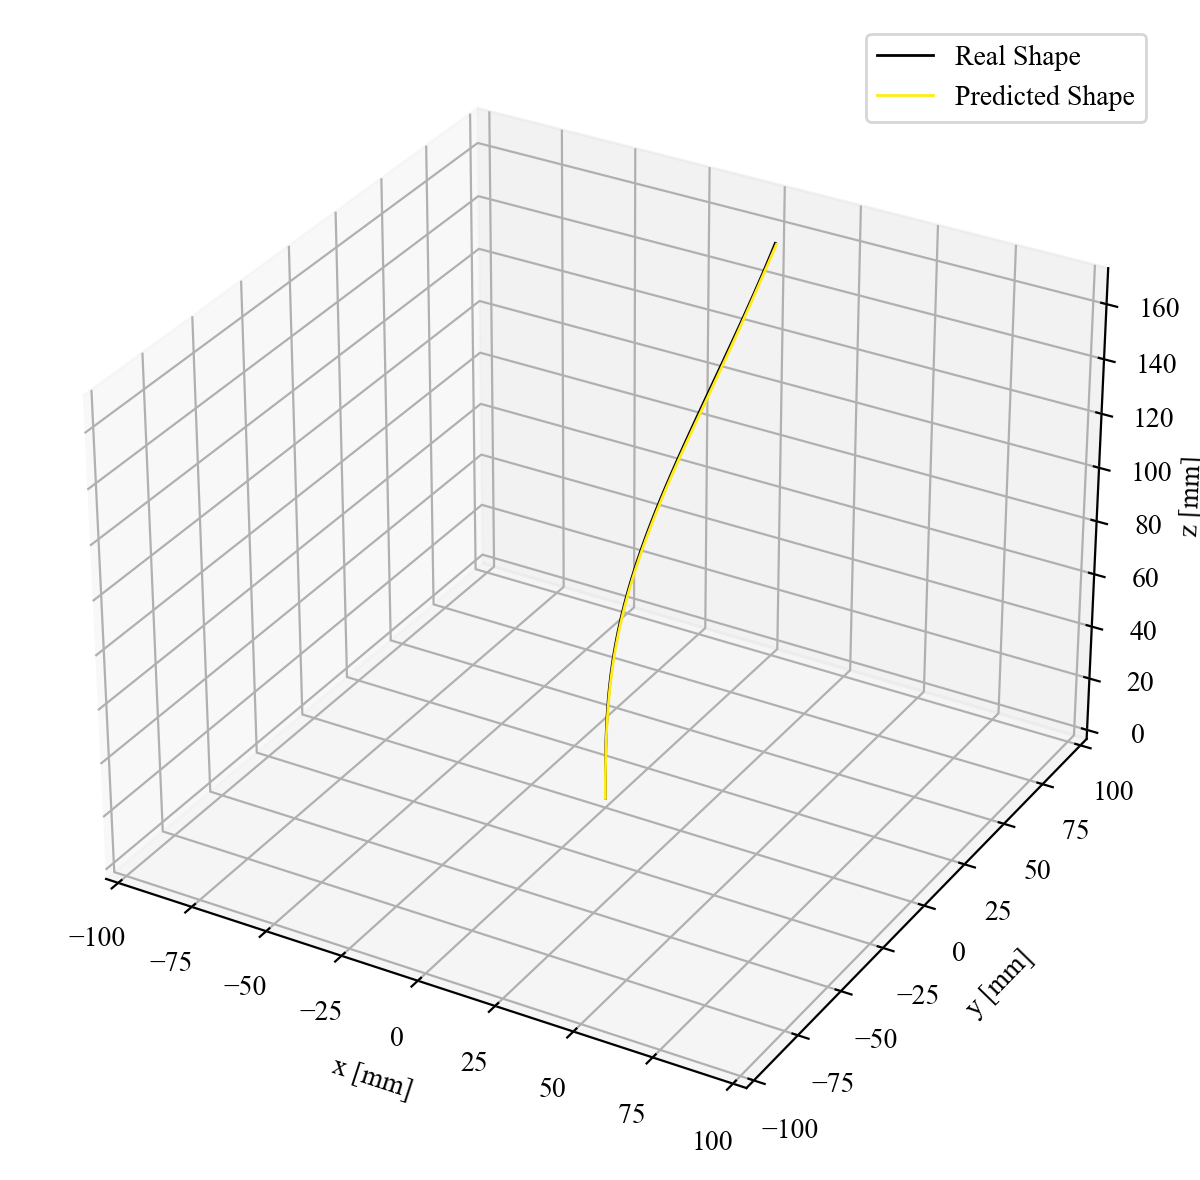

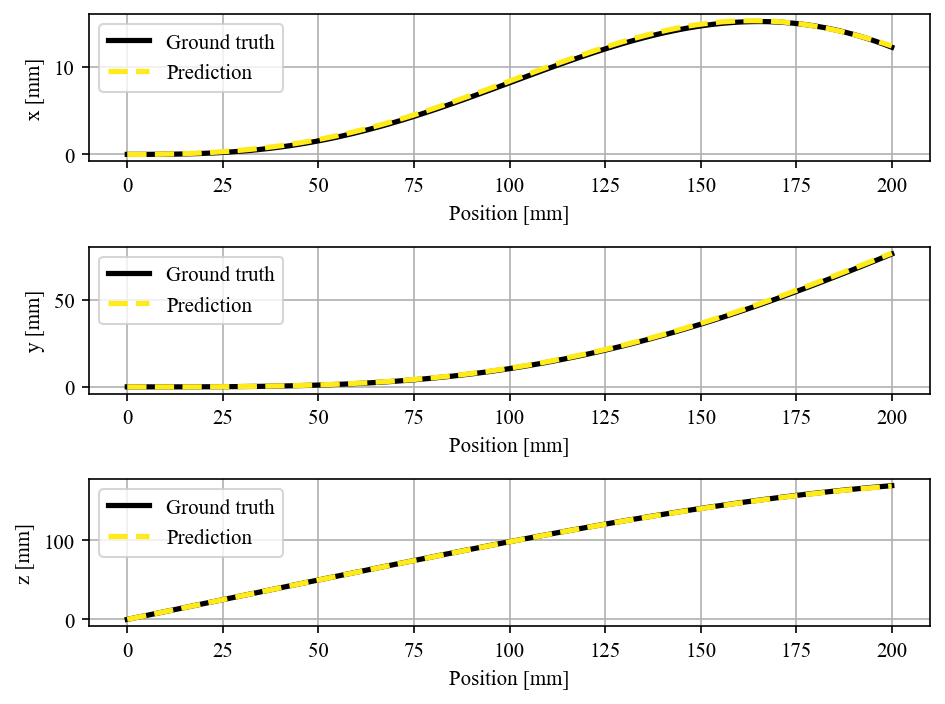

In [14]:
index = indices[5000]
s_sample_mm = s_batch[index] * 1000
xyz_sample_mm = xyz_batch_ode[index] * 1000
res_xyz_sample_mm = res_xyz_batch_ode[index] * 1000
plot_3d(xyz_sample_mm, res_xyz_sample_mm)
plt.savefig(f'sample_{index}.png', dpi=400)
plot_subplot3(s_sample_mm, xyz_sample_mm, res_xyz_sample_mm)
plt.savefig(f'sample_{index}_subplot.png', dpi=400)
## save
